### ***EDA***

In [3]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('Datathon-1-main/Train.csv')

In [5]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


Se hace un revisión rapida del data set para identificar si hay valores nulos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


Se hace una revisión de los outliers

In [7]:
r_sup=df['Cost_of_the_Product'].mean()+3*df['Cost_of_the_Product'].std()
r_inf=df['Cost_of_the_Product'].mean()-3*df['Cost_of_the_Product'].std()

print (r_inf,r_sup)
print (df['Cost_of_the_Product'].min(),df['Cost_of_the_Product'].max())

63.69399013598269 353.4290235322027
96 310


In [8]:
r_sup=df['Discount_offered'].mean()+3*df['Discount_offered'].std()
r_inf=df['Discount_offered'].mean()-3*df['Discount_offered'].std()

print (r_inf,r_sup)
print (df['Discount_offered'].min(),df['Discount_offered'].max())

-37.102443785445416 67.29779882489424
1 65


In [9]:
r_sup=df['Weight_in_gms'].mean()+3*df['Weight_in_gms'].std()
r_inf=df['Weight_in_gms'].mean()-3*df['Weight_in_gms'].std()

print (r_inf,r_sup)
print (df['Weight_in_gms'].min(),df['Weight_in_gms'].max())

-1259.8859846877913 8428.61517682025
1001 7846


De antemano se hizo una exploración general de los datos con un pairplot, donde se identifica que hay unos envíos cuyo peso se aleja de la distribución

<AxesSubplot:ylabel='Frequency'>

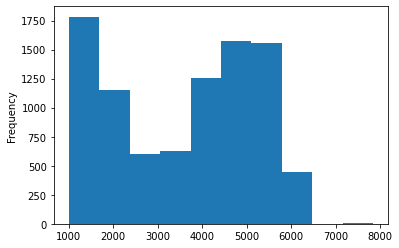

In [10]:
df['Weight_in_gms'].plot.hist()

Se identifica que la mayoria de productos están por debajo de los 7000 mg,por tanto se puede sospechar de que los que están sobre este valor son outliers. Se procede a generar un DataFrame con las modificaciones necesarias, empezando por descartar las 5 entradas cuyo peso está por encima de 7000 mg

In [11]:
df_mod=df.copy()
#df_mod=df_mod[(df['Discount_offered']<10)]
df_mod=df_mod[(df['Weight_in_gms']<7000)]


Se utiliza labelEncoder para las variables categoricas. Esta sirve para pasar las variables categoricas a categorias númericas

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
#df_mod=df.copy()
cols=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
df_mod[cols] = df_mod[cols].apply(LabelEncoder().fit_transform)

In [14]:
df_mod.drop(['ID'],axis=1,inplace=True)


In [15]:
df_mod.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,4,2,177,3,1,0,44,1233,1
1,4,0,4,5,216,2,1,1,59,3088,1
2,0,0,2,2,183,4,1,1,48,3374,1
3,1,0,3,3,176,4,2,1,10,1177,1
4,2,0,2,2,184,3,2,0,46,2484,1


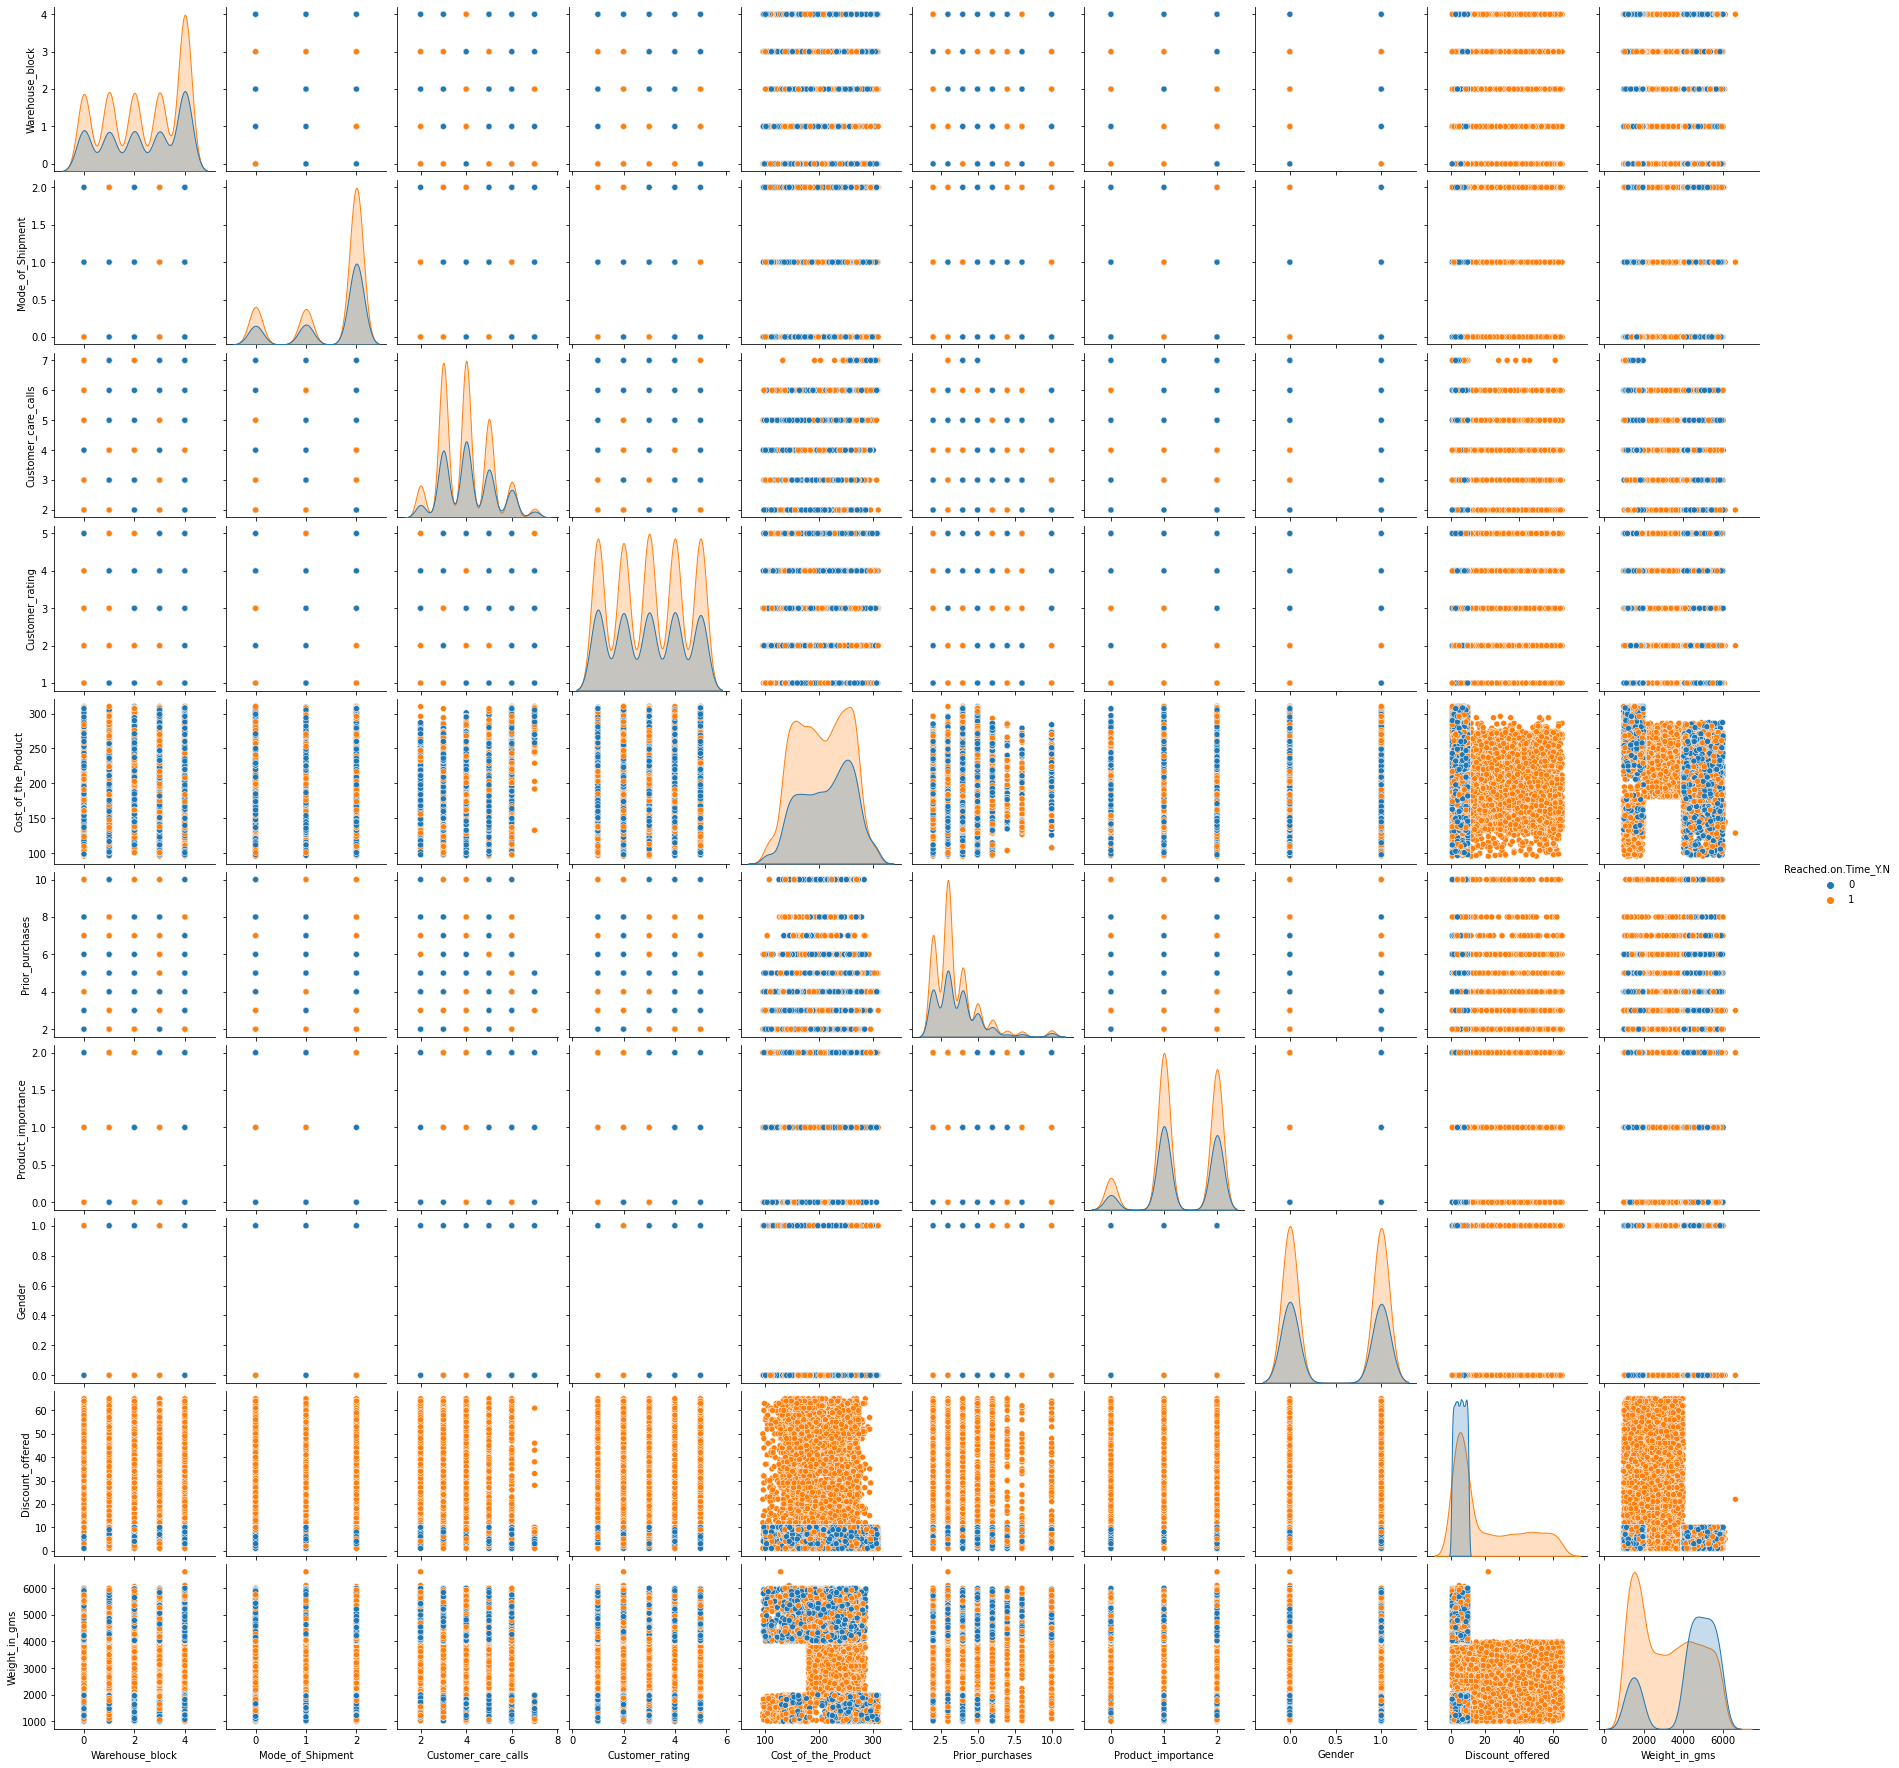

In [274]:
sns.pairplot(df_mod, hue="Reached.on.Time_Y.N")
plt.show()

A partir del pairplot, de primera vista no se ve ninguna que hayan variables relacionadas. 

Se puede destacar que los pedidos que llegaron tarde están concentrados en el menor descuento, indicando que este puede ser uno de los parámetros importante para el modelo. Por otra parte los pedidos de mayor peso y mayor precio tienen una mayor concentración de pedidos entregados tarde.

In [16]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

Importamos la libreria de StandarScaler para normalizar las variables númericas, de tal forma que la correlación no se vea afectada por la diferente escala de los datos. Se visualiza la matriz de correlación

In [17]:
cols=['Cost_of_the_Product','Discount_offered','Weight_in_gms']
df_mod[cols] = sc.fit_transform(df_mod[cols])

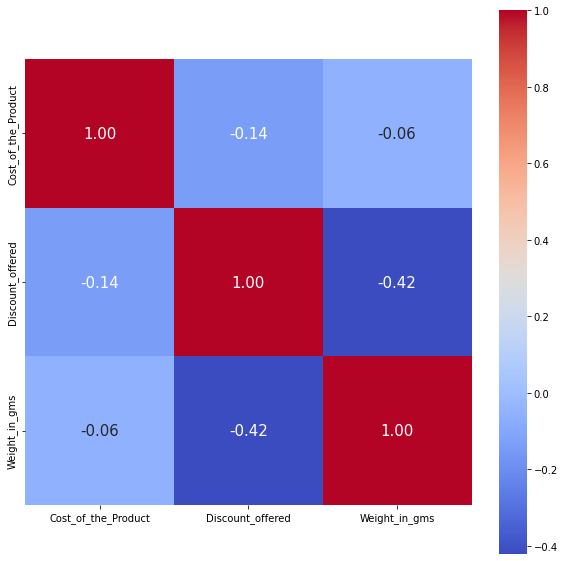

In [18]:
corr = df_mod[cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= cols, 
           yticklabels= cols,
           cmap= 'coolwarm')
plt.show()

Hacemos una tabla de distribución de frecuencias entre  Warehouse_block y Mode_of_Shipment para ver si se presenta algun tipo de dependencia

In [28]:
tab_frec=pd.crosstab(df['Warehouse_block'],df['Mode_of_Shipment'])
tab_frec

Mode_of_Shipment,Flight,Road,Ship
Warehouse_block,,,
A,241,239,1020
B,241,238,1021
C,241,238,1021
D,242,238,1020
F,482,477,2040


In [29]:
import scipy.stats as stat

In [33]:
chi2,p,dof,exp=stat.chi2_contingency(tab_frec)

if p <0.05:
    print(f'Valor de chi-2 {round(p,3)}: Se rechaza la hipótesis nula. Las variables son dependientes')
else:
    print(f'Valor de chi-2 {round(p,3)}: No se rechaza la hipótesis nula. Las variables son independientes')

Valor de chi-2 1.0: No se rechaza la hipótesis nula. Las variables son independientes


### ***Entrenamiento Regresión Logística***

In [97]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5716 entries, 6 to 8998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      5716 non-null   object
 1   Mode_of_Shipment     5716 non-null   object
 2   Customer_care_calls  5716 non-null   int64 
 3   Customer_rating      5716 non-null   int64 
 4   Cost_of_the_Product  5716 non-null   int64 
 5   Prior_purchases      5716 non-null   int64 
 6   Product_importance   5716 non-null   object
 7   Gender               5716 non-null   object
 8   Discount_offered     5716 non-null   int64 
 9   Weight_in_gms        5716 non-null   int64 
 10  Reached.on.Time_Y.N  5716 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 535.9+ KB


In [141]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Se ecogen las columnas que se van a usar para el entrenamiento del modelo

In [124]:
columnas_entrenamiento = ['Customer_care_calls','Cost_of_the_Product','Discount_offered','Weight_in_gms']
#columnas_entrenamiento = ['Cost_of_the_Product','Weight_in_gms']
X = df_mod[columnas_entrenamiento]
y = df_mod['Reached.on.Time_Y.N']

Se divide el archivo de train, en uno que se va a utilizar para el apendizaje del modelo y el otro para evaluar como se comporta el modelo con datos que no ha visto

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Se hace el entrenamiento para una regresión logistica, utilizando el modelo generado por sklearn

In [38]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

Se hacen las predicciones con base al modelo entrenado anteriormente

In [39]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

Se evalua el rendimiento del modelo con las métricas de recall y accuracy

In [40]:
precision_train = metrics.recall_score(y_train, y_pred_train)
precision_test = metrics.recall_score(y_test, y_pred_test)

print(precision_train)
print(precision_test)

0.743935983995999
0.7119533527696793


In [41]:
precision_train = metrics.accuracy_score(y_train, y_pred_train)
precision_test = metrics.accuracy_score(y_test, y_pred_test)

print(precision_train)
print(precision_test)

0.67450357426529
0.6613560577991849


In [42]:
y_q=pd.Series(y_pred_train)
y_q.value_counts()

1    4000
0    2295
dtype: int64

Se llama el archivo de Test sobre el cual se va a querer hacer las predicciones, para ello el archivo debe tener la misma estructura que se uso en los datos de entrenamiento

In [74]:
df_test=pd.read_csv('Datathon-1-main/Test.csv')

In [75]:
cols=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
df_test[cols] = df_test[cols].apply(LabelEncoder().fit_transform)
df_test.drop(['ID'],axis=1,inplace=True)

cols=['Cost_of_the_Product','Discount_offered','Weight_in_gms']
df_test[cols] = sc.fit_transform(df_test[cols])

In [76]:
X_t = df_test[columnas_entrenamiento]

In [63]:
X_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cost_of_the_Product  2000 non-null   float64
 1   Weight_in_gms        2000 non-null   float64
dtypes: float64(2)
memory usage: 31.4 KB


Una vez las entradas del archivo de testeo tienen la misma estructura de entrenamiento, se prosigue a hacer las predicciones basadas en el modelo entrenado anteriormente

In [47]:
y_pred=clf.predict(X_t)
y_out=pd.Series(y_pred)

In [48]:
y_out.value_counts()

1    1344
0     656
dtype: int64

In [ ]:
y_out.to_csv('Juanita1345-5.csv',index=False)

### ***Entrenamiento SVM***

Se utiliza un estimador para evaluar cuales hiperparametros tienen mejor rendimiento para el modelo 

In [215]:
# Hiperparametros a evaluar
search_space = {
    'kernel': ['linear','sigmoid', 'rbf'],
    'C': [0.01, 0.1, 1,10,100,1000],
    'gamma': [0,0.1,1,10,100],
    'coef0': [0,0.1,1],
}

In [216]:
#Evaluación de hiperparámetros
svc_ = SVC()
model = GridSearchCV(svc_, param_grid=search_space, cv=5)

# Entrenamos
model.fit(X_train, y_train)

print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

c:\Users\Juanita\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Juanita\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Juanita\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 237, in fit
    raise ValueError(msg)
ValueError: gamma value must be > 0; 0 is invalid. Use a positive number or use 'auto' to set

Mejores hiperparámetros: {'C': 0.1, 'coef0': 0, 'gamma': 10, 'kernel': 'rbf'}
Mejor Score: 0.7072279586973789



Se hace la selección de las columnas a evaluar

In [218]:
#columnas_entrenamiento = ['Customer_care_calls','Cost_of_the_Product','Product_importance','Discount_offered','Weight_in_gms']
columnas_entrenamiento = ['Cost_of_the_Product','Weight_in_gms']
X = df_mod[columnas_entrenamiento]
y = df_mod['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [219]:
#classifier = SVC(kernel='linear', gamma='auto', probability=True)
classifier = SVC(C=0.1,kernel='rbf', gamma=10, probability=True)
classifier.fit(X_train, y_train)

SVC(C=0.1, gamma=10, probability=True)

In [220]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [221]:
precision_train = metrics.recall_score(y_train, y_pred_train)
precision_test = metrics.recall_score(y_test, y_pred_test)

print(precision_train)
print(precision_test)

0.6404101025256314
0.60932944606414


In [222]:
precision_train = metrics.accuracy_score(y_train, y_pred_train)
precision_test = metrics.accuracy_score(y_test, y_pred_test)

print(precision_train)
print(precision_test)

0.715647339158062
0.693960726194887


In [223]:
X_t = df_test[columnas_entrenamiento]

In [224]:
y_pred=classifier.predict(X_t)
y_out=pd.Series(y_pred)

In [225]:
y_out.value_counts()

0    1382
1     618
dtype: int64

In [214]:
y_out.to_csv('Juanita1345-6.csv',index=False)